## 0.1) imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from colorama import Fore, Style
from dateutil.parser import parse
from typing import Dict, List, Tuple, Sequence
from datetime import datetime

from power.params import *
from power.ml_ops.data import get_data_with_cache, load_data_to_bq, clean_pv_data, clean_forecast_data
from power.ml_ops.model import initialize_model, compile_model, train_model, evaluate_model
from power.ml_ops.registry import load_model, save_model, save_results
from power.ml_ops.cross_val import get_X_y_seq, get_X_y_seq_pv

from power.utils import plot_loss_mae


2024-11-01 17:17:21.128353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 17:17:21.569986: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-01 17:17:21.576966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 17:17:25.110307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
X = np.load('X_train.npy')
y = np.load('y_train.npy')

X_full = np.load('X_train_full.npy')
y_full = np.load('y_train_full.npy')

# 1) Train Function

In [3]:
def train(
        min_date = '2017-10-07 00:00:00',
        max_date = '2019-12-31 23:00:00',
        split_ratio: float = 0.02, # 0.02 represents ~ 1 month of validation data on a 2009-2015 train set
        learning_rate=0.02,
        batch_size = 32,
        patience = 5,
        forecast_features = False
    ) -> float:

    """
    - Download processed data from your BQ table (or from cache if it exists)
    - Train on the preprocessed dataset (which should be ordered by date)
    - Store training results and model weights

    Return val_mae as a float
    """

    print(Fore.MAGENTA + "\n⭐️ Use case: train" + Style.RESET_ALL)
    print(Fore.BLUE + "\nLoading preprocessed validation data..." + Style.RESET_ALL)


    # --First-- Load processed PV data using `get_data_with_cache` in chronological order
    query_pv = f"""
        SELECT *
        FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
        ORDER BY utc_time
    """

    data_processed_pv_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
    data_processed_pv = get_data_with_cache(
        gcp_project=GCP_PROJECT,
        query=query_pv,
        cache_path=data_processed_pv_cache_path,
        data_has_header=True
    )
    # the processed PV data from bq needs to be converted to datetime object
    data_processed_pv.utc_time = pd.to_datetime(data_processed_pv.utc_time,utc=True)

    if data_processed_pv.shape[0] < 240:
        print("❌ Not enough processed data retrieved to train on")
        return None

    # Split the data into training and testing sets
    train_pv = data_processed_pv[(data_processed_pv['utc_time'] > min_date) \
                                 & (data_processed_pv['utc_time'] < max_date)]


    if forecast_features:
    # --Second-- Load processed Weather Forecast data in chronological order
        query_forecast = f"""
            SELECT *
            FROM {GCP_PROJECT}.{BQ_DATASET}.processed_weather_forecast
            ORDER BY forecast_dt_unixtime, slice_dt_unixtime
        """

        data_processed_forecast_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_weather_forecast.csv")
        data_processed_forecast = get_data_with_cache(
            gcp_project=GCP_PROJECT,
            query=query_forecast,
            cache_path=data_processed_forecast_cache_path,
            data_has_header=True
        )



        if data_processed_forecast.shape[0] < 240:
            print("❌ Not enough processed data retrieved to train on")
            return None

        # Split the data into training and testing sets
        train_forecast = data_processed_forecast

        X_train, y_train = get_X_y_seq(train_pv,
                                    train_forecast,
                                    number_of_sequences=10_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)

    else:
        X_train, y_train = get_X_y_seq_pv(train_pv,
                                    number_of_sequences=10_000,
                                    input_length=48,
                                    output_length=24,
                                    gap_hours=12)

    # Train model using `model.py`
    model = load_model()

    if model is None:
        model = initialize_model(X_train, y_train, n_unit=24)


    model = compile_model(model, learning_rate=learning_rate)
    model, history = train_model(model,
                                X_train,
                                y_train,
                                validation_split = 0.3,
                                batch_size = 32,
                                epochs = 50
                                )

    val_mae = np.min(history.history['val_mae'])

    params = dict(
        context="train",
        training_set_size=f'Training data from {min_date} to {max_date}',
        row_count=len(X_train),
    )

    # Save results on the hard drive using taxifare.ml_logic.registry
    save_results(params=params, metrics=dict(mae=val_mae))

    # Save model weight on the hard drive (and optionally on GCS too!)
    save_model(model=model)

    print("✅ train() done \n")

    return X_train , y_train, model, history

In [4]:
# X_train , y_train, model, history = train(forecast_features= False)
# X_train.shape, y_train.shape

In [5]:
# np.save(file= 'X_train', arr= X_train)
# np.save(file= 'y_train', arr= y_train)

X = np.load('X_train.npy')
y = np.load('y_train.npy')

In [6]:
X.shape, y.shape

((10000, 48, 1), (10000, 24, 1))

In [7]:
# X_train_full , y_train_full = train(forecast_features= True)
# X_train_full.shape, y_train_full.shape

In [8]:
# np.save(file= 'X_train_full', arr= X_train_full)
# np.save(file= 'y_train_full', arr= y_train_full)

X_full = np.load('X_train_full.npy')
y_full = np.load('y_train_full.npy')

In [9]:
X_full.shape, y_full.shape

((10000, 48, 5), (10000, 24, 1))

# 2) Model Evaluation 

## 2.1) historical PV production data training

2024-11-01 17:43:59.563597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-01 17:43:59.568282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-01 17:43:59.570655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

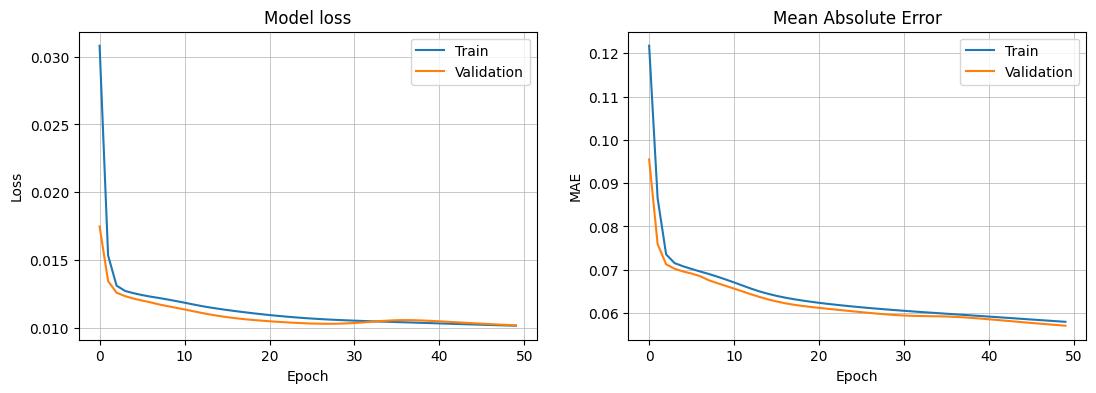

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 48, 1)            3         
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 24)                2496      
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
Total params: 3,099
Trainable params: 3,096
Non-trainable params: 3
_________________________________________________________________


In [14]:
model = initialize_model(X, y)
model = compile_model(model, learning_rate= 1e-3)
model, history = train_model(model, X, y)
plot_loss_mae(history)
model.summary()

## 2.2) historical PV production + historical weather-forecast data

2024-11-01 17:28:29.548302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-01 17:28:29.552757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-01 17:28:29.556151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

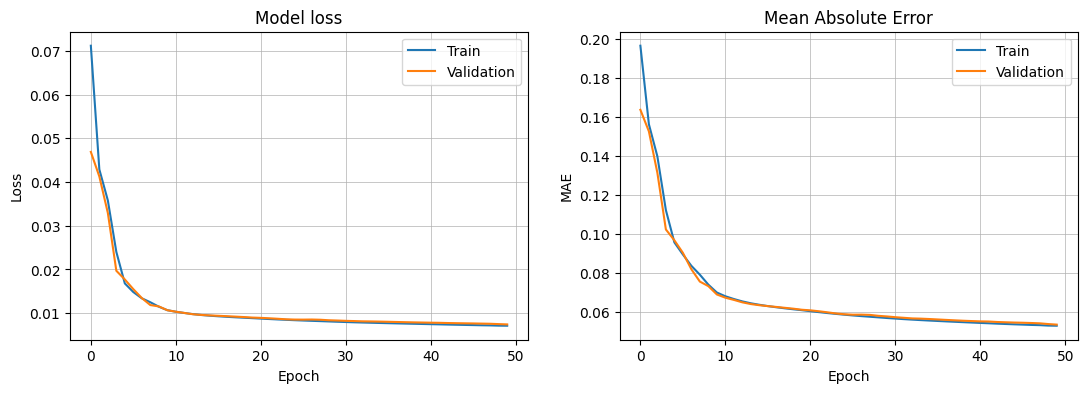

In [11]:
model = initialize_model(X_full, y_full)
model = compile_model(model, learning_rate=1e-3)
model, history = train_model(model, X_full, y_full)
plot_loss_mae(history)
# model.summary()